In [40]:
import jax
import jax.numpy as jnp
import jax.random as jr 

import flowjax
from flowjax.bijections import (
    Affine,
    Invert,
    MaskedAutoregressive,
    RationalQuadraticSpline,
    Stack,
    Tanh,
    Identity
)
from flowjax.bijections.utils import Identity
from flowjax.distributions import Normal, Transformed, Uniform, _StandardUniform
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data
from flowjax.wrappers import NonTrainable

from frugal_flows.bijections import UnivariateNormalCDF

import matplotlib.pyplot as plt
import equinox as eqx
from collections.abc import Callable
import jax.nn as jnn
from typing import ClassVar

seed = 5

In [63]:
# Set the random seed
key = jr.PRNGKey(seed)

# Generate N Bernoulli samples
N = 10000
p = 0.5
x = jr.bernoulli(key, p=p, shape=(N, 1)).astype(int)

# Calculate y conditional on x
mean = 5 * x  + 2
std_dev = 1
noise = jr.normal(jr.PRNGKey(seed+1), shape=(N,1))

# Generate Gaussian variables with specified mean and standard deviation
y = std_dev * noise + mean

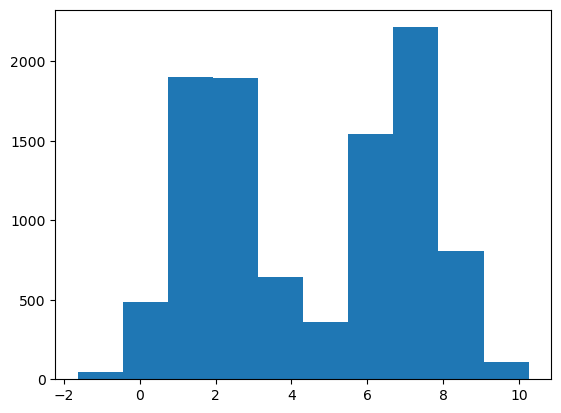

In [64]:
plt.hist(y.T);

In [54]:
nvars = 1
key, subkey = jr.split(jr.PRNGKey(seed))

base_dist = flowjax.distributions._StandardUniform((1,))

# base_dist = Uniform(-jnp.zeros(nvars), jnp.ones(nvars))
marginal_transform = Stack([UnivariateNormalCDF(
    ate=5., 
    const=3., 
    scale=3., 
    cond_dim=1
)])
flow = Transformed(base_dist, Invert(marginal_transform))

key, subkey = jr.split(key)

# Train 
flow, losses = fit_to_data(
    key=subkey,
    dist=flow,
    x=y,
    condition=x,
    learning_rate=1e-2,
    max_patience=20,
    max_epochs=700,
)

  6%|▋         | 45/700 [00:00<00:06, 102.58it/s, train=1.4294357, val=1.4030145 (Max patience reached)]


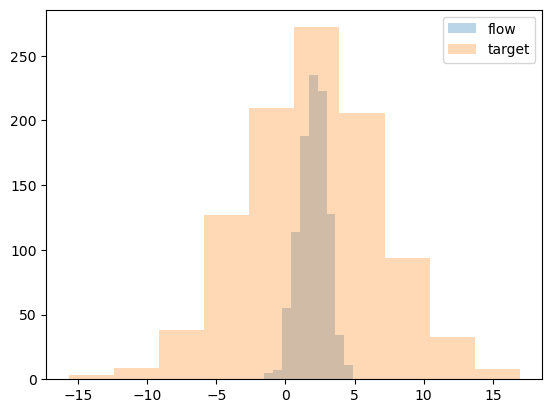

In [55]:
# plt.hist(*flow.sample(key, (1000, ), condition=jnp.zeros(1)).T, label="flow", alpha=0.3)
plt.hist(*flow.sample(key, (1000, ), condition=jnp.zeros(1)).T,label="flow", alpha=0.3)

# plt.hist(*flow.sample(key, (1000, ), condition=jnp.zeros(1)).T, label="flow", alpha=0.3)
plt.hist(*y.T, label="target", alpha=0.3)
plt.legend()

In [57]:
print(flow.bijection.bijection.bijections[0].ate)
print(flow.bijection.bijection.bijections[0].const)
print(flow.bijection.bijection.bijections[0].scale)

5.023919
2.00996
0.9976782
